In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-pbd0luan/pyyaml_f3052107d60b4960b0d163d176f0b941/setup.py", line 291, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 185, in setup
          return run_commands(dist)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 201, in run_commands
          dist.run_commands()
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/dist.py", line 969, in run_commands
          self.run_command(cmd)
        File "/opt/conda/lib/pyth

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  2.1 ; cuda:  2.1.2
detectron2: 0.6


In [3]:
import os, cv2, random, json
from tqdm import tqdm
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json, cv2, random
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# detectron2
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [4]:
# Define the mapping from class IDs to class names
class_names_dict = {
    0: 'pedestrian',
    1: 'people',
    2: 'bicycle',
    3: 'car',
    4: 'van',
    5: 'truck',
    6: 'tricycle',
    7: 'awning-tricycle',
    8: 'bus',
    9: 'motor'
}

In [5]:
def get_visdrone_dicts(img_dir, ann_dir):
    dataset_dicts = []
    for idx, filename in enumerate(os.listdir(img_dir)):
        record = {}

        img_path = os.path.join(img_dir, filename)
        height, width = cv2.imread(img_path).shape[:2]

        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        ann_file = os.path.join(ann_dir, filename.replace('.jpg', '.txt'))
        objs = []

        with open(ann_file, 'r') as file:
            lines = file.readlines()
            for line in lines:
                elements = line.strip().split(',')
                x_min, y_min, w, h, class_id = int(elements[0]), int(elements[1]), int(elements[2]), int(elements[3]), int(elements[5]) - 1
                if (0 <= class_id <= 9 and w  > 0 and h > 0):
                    obj = {
                    "bbox": [x_min, y_min, x_min + w, y_min + h],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": class_id,
                    }
                    objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [6]:
# Path train
image_train_folder = "/kaggle/input/visdrone2019/VisDrone2019-DET-train/VisDrone2019-DET-train/images/"
annotation_train_folder = "/kaggle/input/visdrone2019/VisDrone2019-DET-train/VisDrone2019-DET-train/annotations/"

In [7]:
# Path valid
image_val_folder = "/kaggle/input/visdrone2019/VisDrone2019-DET-val/VisDrone2019-DET-val/images/"
annotation_val_folder = "/kaggle/input/visdrone2019/VisDrone2019-DET-val/VisDrone2019-DET-val/annotations/"

In [8]:
# Path test
image_test_folder = "/kaggle/input/visdrone2019/VisDrone2019-DET-test-dev/images/"
annotation_test_folder = "/kaggle/input/visdrone2019/VisDrone2019-DET-test-dev/annotations/"


In [9]:
# Register datasets
def register_visdrone_datasets():
    DatasetCatalog.register("visdrone_train", lambda: get_visdrone_dicts(image_train_folder, annotation_train_folder))
    MetadataCatalog.get("visdrone_train").set(thing_classes=list(class_names_dict.values()))

    DatasetCatalog.register("visdrone_val", lambda: get_visdrone_dicts(image_val_folder, annotation_val_folder))
    MetadataCatalog.get("visdrone_val").set(thing_classes=list(class_names_dict.values()))

    DatasetCatalog.register("visdrone_test", lambda: get_visdrone_dicts(image_test_folder, annotation_test_folder))
    MetadataCatalog.get("visdrone_test").set(thing_classes=list(class_names_dict.values()))

In [10]:
register_visdrone_datasets()

visdrone_metadata = MetadataCatalog.get("visdrone_train")

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("visdrone_train",)
cfg.DATASETS.TEST = ("visdrone_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained model weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00005
cfg.SOLVER.MAX_ITER = 10000   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_names_dict)  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [12]:
import torch
print(torch.cuda.is_available())

True


In [13]:
import logging
from detectron2.utils.logger import setup_logger

setup_logger()

<_Logger detectron2 (DEBUG)>

In [14]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/13 11:13:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 199MB/s]                             


[06/13 11:15:38 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/13 11:15:47 d2.utils.events]:  eta: 0:47:45  iter: 19  total_loss: 3.86  loss_cls: 2.386  loss_box_reg: 0.7035  loss_rpn_cls: 0.4917  loss_rpn_loc: 0.3323    time: 0.2862  last_time: 0.2861  data_time: 0.0153  last_data_time: 0.0048   lr: 9.9905e-07  max_mem: 2758M


2024-06-13 11:15:49.011898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 11:15:49.012029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 11:15:49.132275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[06/13 11:16:03 d2.utils.events]:  eta: 0:46:46  iter: 39  total_loss: 3.895  loss_cls: 2.39  loss_box_reg: 0.6885  loss_rpn_cls: 0.4252  loss_rpn_loc: 0.3887    time: 0.2734  last_time: 0.2819  data_time: 0.0062  last_data_time: 0.0060   lr: 1.998e-06  max_mem: 2758M
[06/13 11:16:08 d2.utils.events]:  eta: 0:46:31  iter: 59  total_loss: 3.706  loss_cls: 2.352  loss_box_reg: 0.6756  loss_rpn_cls: 0.3421  loss_rpn_loc: 0.3303    time: 0.2702  last_time: 0.2430  data_time: 0.0057  last_data_time: 0.0057   lr: 2.997e-06  max_mem: 4934M
[06/13 11:16:13 d2.utils.events]:  eta: 0:46:10  iter: 79  total_loss: 3.845  loss_cls: 2.284  loss_box_reg: 0.6477  loss_rpn_cls: 0.4801  loss_rpn_loc: 0.3845    time: 0.2675  last_time: 0.3015  data_time: 0.0062  last_data_time: 0.0059   lr: 3.9961e-06  max_mem: 4934M
[06/13 11:16:18 d2.utils.events]:  eta: 0:45:45  iter: 99  total_loss: 3.391  loss_cls: 2.243  loss_box_reg: 0.7457  loss_rpn_cls: 0.1383  loss_rpn_loc: 0.278    time: 0.2673  last_time: 0.2

In [15]:
# Save the final model weights
torch.save(trainer.model.state_dict(), os.path.join("/kaggle/working/output", "visdrone2019_detectron2.pth"))

# **Evaluate on test set**

In [16]:
model_weights_path = "/kaggle/working/output/visdrone2019_detectron2.pth"

In [17]:
cfg.MODEL.WEIGHTS = model_weights_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25  # Set a threshold for this model
cfg.DATASETS.TEST = ("visdrone_test", )

In [18]:
from detectron2.engine import DefaultPredictor

predictor = DefaultPredictor(cfg)

[06/13 11:59:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output/visdrone2019_detectron2.pth ...


### Predict 5 random images

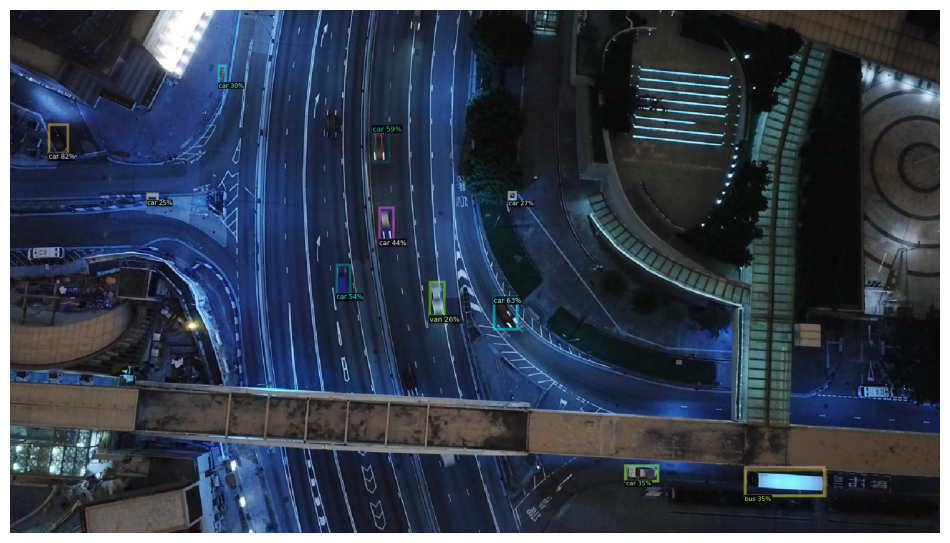

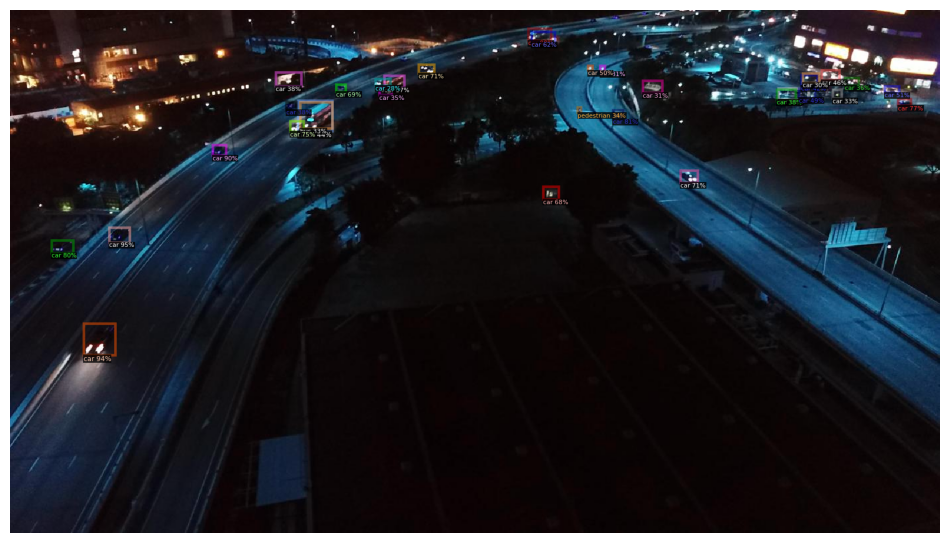

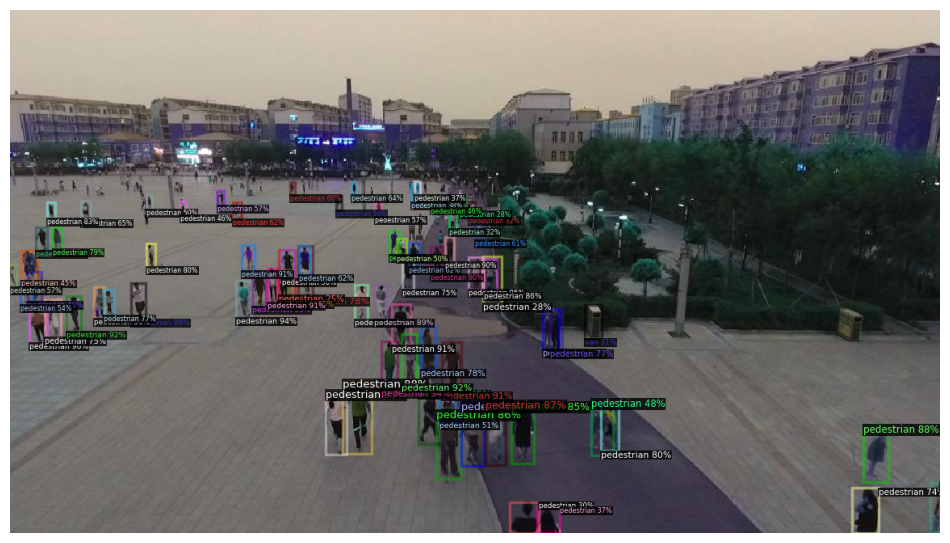

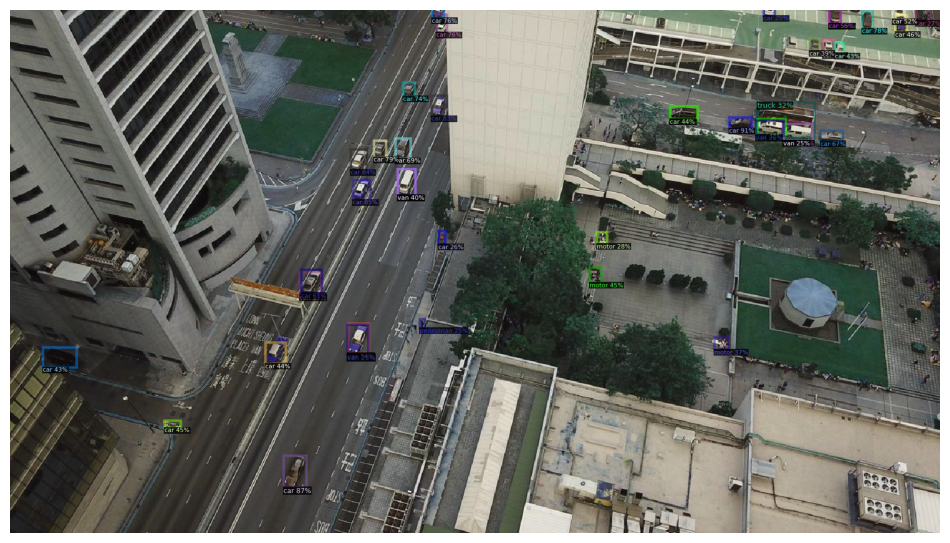

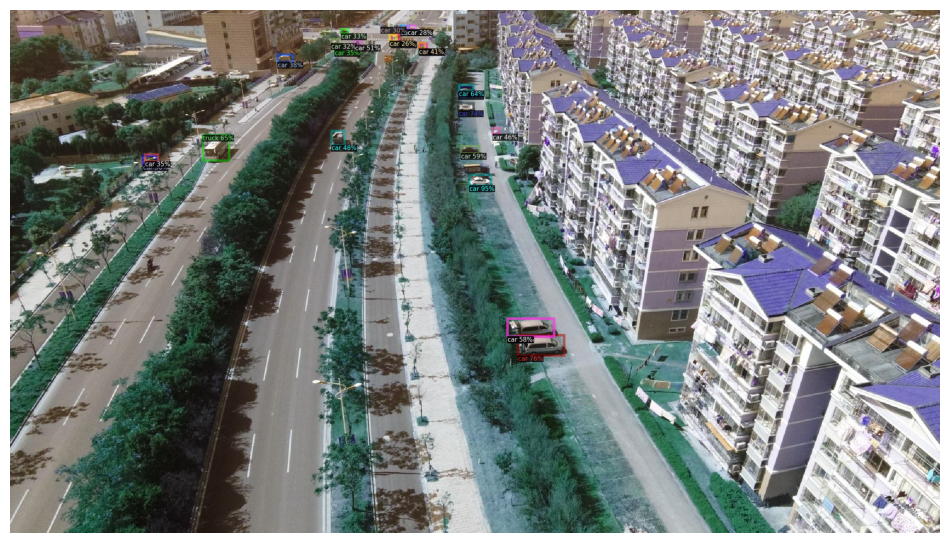

In [19]:
# Load the metadata for the test dataset
visdrone_metadata = MetadataCatalog.get("visdrone_test")

# Load the test dataset
dataset_dicts = get_visdrone_dicts(image_test_folder, annotation_test_folder)

# Run inference and visualize some results
for d in random.sample(dataset_dicts, 5):  # Change the number 5 to visualize more images
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=visdrone_metadata, scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.figure(figsize=(12, 12))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

In [20]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("visdrone_test", cfg, False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "visdrone_test")
print(inference_on_dataset(trainer.model, test_loader, evaluator))

[06/13 11:59:49 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [06/13 11:59:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/13 11:59:49 d2.evaluation.coco_evaluation]: Trying to convert 'visdrone_test' to COCO format ...
[06/13 11:59:49 d2.data.datasets.coco]: Converting annotations of dataset 'visdrone_test' to COCO format ...)
[06/13 12:00:01 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/13 12:00:16 d2.data.datasets.coco]: Conversion finished, #images: 1610, #annotations: 75102
[06/13 12:00:16 d2.data.datasets.coco]: Caching COCO format annotations at './output/visdrone_test_coco_format.json' ...
[06/13 12:00:31 d2.data.build]: Distribution of instances among all 10 categories:
|  category  | #instances   |   category    | #instances   |  category  | #instances   |
|:----------:|:-------------|:-----

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/13 12:00:32 d2.evaluation.evaluator]: Inference done 11/1610. Dataloading: 0.0015 s/iter. Inference: 0.0648 s/iter. Eval: 0.0004 s/iter. Total: 0.0667 s/iter. ETA=0:01:46
[06/13 12:00:37 d2.evaluation.evaluator]: Inference done 86/1610. Dataloading: 0.0018 s/iter. Inference: 0.0651 s/iter. Eval: 0.0004 s/iter. Total: 0.0675 s/iter. ETA=0:01:42
[06/13 12:00:42 d2.evaluation.evaluator]: Inference done 160/1610. Dataloading: 0.0019 s/iter. Inference: 0.0654 s/iter. Eval: 0.0004 s/iter. Total: 0.0677 s/iter. ETA=0:01:38
[06/13 12:00:47 d2.evaluation.evaluator]: Inference done 235/1610. Dataloading: 0.0019 s/iter. Inference: 0.0651 s/iter. Eval: 0.0004 s/iter. Total: 0.0675 s/iter. ETA=0:01:32
[06/13 12:00:52 d2.evaluation.evaluator]: Inference done 310/1610. Dataloading: 0.0019 s/iter. Inference: 0.0650 s/iter. Eval: 0.0004 s/iter. Total: 0.0673 s/iter. ETA=0:01:27
[06/13 12:00:57 d2.evaluation.evaluator]: Inference done 385/1610. Dataloading: 0.0019 s/iter. Inference: 0.0649 s/iter. E

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/13 12:02:20 d2.evaluation.evaluator]: Total inference time: 0:01:48.942840 (0.067877 s / iter per device, on 1 devices)
[06/13 12:02:20 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:44 (0.065122 s / iter per device, on 1 devices)
[06/13 12:02:22 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/13 12:02:22 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/13 12:02:23 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.74s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=90.30s).
Accumulating evaluation results...
DONE (t=3.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.098
 Averag